In [13]:
from IPython.display import HTML

import numpy as np
import jax.random as jr
from sklearn.decomposition import PCA

from src.model.nca import GrowingNCA
from src.utils import load_pytree
from src.visualisation.utils import plot_img, plot_dev_path

In [32]:
nca = GrowingNCA((64, 64), num_dev_steps=(48, 96), key=jr.key(42))
nca = load_pytree('data/examples/', 'model_01', nca)

In [33]:
output, dev_path = nca(jr.key(23), steps=96)
# plot_img(output);
ani = plot_dev_path(dev_path[:, :4]);
HTML(ani.to_jshtml())

In [53]:
S, C, H, W = dev_path.shape
all_cell_states = dev_path.transpose(0, 2, 3, 1).reshape(S * H * W, C)
alive_idx = np.nonzero(all_cell_states[:, 3:4])
print(len(alive_idx[0]))
alive = all_cell_states[alive_idx[0]]

pca = PCA(n_components=3)
alive_pca = pca.fit_transform(alive[..., 4:])

path_pca = np.zeros((len(all_cell_states), 3))
path_pca[alive_idx[0]] = alive_pca
# all_states_pca = all_states_pca.reshape(S, H, W, 3)

16714


In [44]:
path_pca_image = path_pca.reshape(S, H, W, 3).transpose(0, 3, 1, 2)
ani = plot_dev_path(path_pca_image);
HTML(ani.to_jshtml())

ValueError: RGBA values should be within 0-1 range

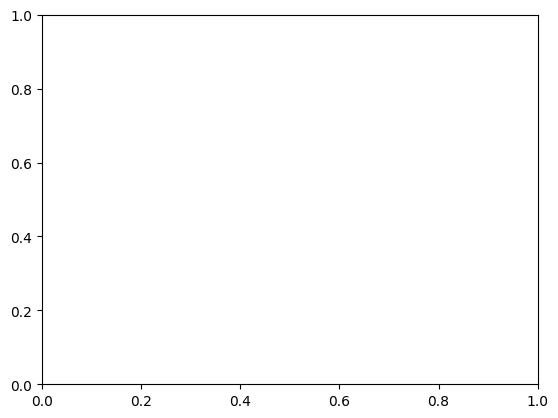

In [56]:
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
position_pca = pca.fit_transform(alive[..., 4:])
plt.scatter(position_pca[:, 0], position_pca[:, 1], c=alive_pca / (alive_pca.max() - alive_pca.min()))